<h1 align="center">The Blue-Chip Ratio (BCR) and Winning In College Football</h1>
<h2 align="center">WGU D195 Capstone 2023</h2>

<h4 align="center">Scott Phelps, Bachelor of Data Management/Data Analytics Program, Western Governors University</h4>

## Table of Contents
1. [Introduction](#intro)
- 1.1 [Load Datasets](#data)
2. [Data Wrangling](#wrangling)
3. [Exploratory Data Analysis](#eda)
4. [Linear Regression](#regression)
- 4.1 [Sklearn](#sk)
- 4.2 [Statsmodels](#sm)
5. [Conclusion](#conclusion)


<a id='intro'></a>
## 1. Introduction

While several factors might account for success in college football, there seems to be a consensus among many coaches, analysts, and recruiting staff that the blue-chip ratio should be a major area of focus when they build their teams. The wider the gap between 4- and 5-star players and the rest of the players appears to impact the end result, a winning season. This project will attempt to provide support for this using regression.

This project is using data collected from online sources, such as Kaggle and sports-statistics.com.  It consists of three datasets: a series of csv files storing player statistics and the teams they played for, another dataset of football recruits, and a teams dataset on team performance (wins, losses, ec) each year. The teams dataset is stored as a .db file which is read in using the sqlite3 library. The first step is to load the libraries and modules so we'll do that now.

In [1]:
# importing libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import importlib
import seaborn as sns
import os

%matplotlib inline

import statsmodels.api as sm

from importlib import reload
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_rows', 1000); 
pd.set_option('display.max_columns', 1000); 
pd.set_option('display.width', 1000)

The libraries and modules, or packages, contain robust tools and features we can use to perform every task in our project.

In [2]:
# checking the current working dir
os.getcwd()

'C:\\Users\\sjohn\\OneDrive\\Documents\\D195 Capstone\\DataFrames'

<a id='data'></a>
<h3>1.1 Load Datasets</h3>

In [3]:
# READING IN THE DATA
# ALL-FBS FOOTBALL PLAYER STATS, csv's from sports-statistics.com
# these dfs will be concatenated together and later merged with the recruits table

# current working dir set to path
path = r"C:\Users\sjohn\OneDrive\Documents\D195 Capstone\DataFrames"
files = [x for x in os.listdir('.') if x.endswith('.csv')]
file = [os.path.splitext(os.path.basename(x))[0] for x in files]


df_dict = {}
for i in range(len(files)):
    df_dict[file[i]] = pd.read_csv(files[i])
    
# these five will be concatenated later
df_def = df_dict['df_all_defense']
df_pas = df_dict['df_all_passing']
df_rec = df_dict['df_all_receiving']
df_rus = df_dict['df_all_rushing']
df_sco = df_dict['df_all_scoring']

# the five dataframes below are additional from sports-statistics.com
df_kick = df_dict['df_all_kicking']
df_kickoff = df_dict['df_all_kickoff']
df_kickoffR = df_dict['df_all_kickoff-return']
df_punt = df_dict['df_all_punting']
df_puntR = df_dict['df_all_punt-return']

df_new = pd.concat([df_kick, df_kickoff, df_kickoffR, df_punt, df_puntR], ignore_index=True)
        
# # FOOTBALL TEAM STATS - .db file, KAGGLE 2013-2020

folder_path1 = "/Users/sjohn/OneDrive/Documents/D195 Capstone/DataFrames/csv2013-2020"

cnx = sqlite3.connect(f'{folder_path1}/cfb.db')

season_data = {}
for year in range(2013, 2021):
    temp_df = pd.read_sql_query(f"SELECT * FROM cfb{year}", cnx)
    temp_df['Year'] = year
    season_data[f'df{year}'] = temp_df


# 'df_team_stats' contains all of the team data above in one dataframe(concat)
df_teams_stats = pd.read_csv(r'C:\Users\sjohn\OneDrive\Documents\D195 Capstone\DataFrames\csv2013-2020\df_teams2013_2020.csv', index_col=False)
df_recruits = pd.read_csv(r'C:\Users\sjohn\OneDrive\Documents\D195 Capstone\Datasets\CFB recruiting and portal\CFB_recruits.csv', index_col=False)

# these datasets to be used later - df's are the result of most of the steps below and some minor editing in Excel
recruits = pd.read_csv(r'C:\Users\sjohn\OneDrive\Documents\D195 Capstone\DataFrames\csv2013-2020\df_recruits.csv', index_col=False)
teams = pd.read_csv(r'C:\Users\sjohn\OneDrive\Documents\D195 Capstone\DataFrames\csv2013-2020\df_teams.csv', index_col=False)
df_dict.keys()

dict_keys(['df_all_defense', 'df_all_kicking', 'df_all_kickoff-return', 'df_all_kickoff', 'df_all_passing', 'df_all_punt-return', 'df_all_punting', 'df_all_receiving', 'df_all_rushing', 'df_all_scoring'])

First we need to perfrom some data wrangling. We'll look at a few rows then examine the structure of the data to look for data that is missing and to get a glimpse of each row and column count and datatype. Some of the datasets we will use will have missing data which is expected, and for the purposes of this analysis some missing data is acceptable. Later through a series of queries we'll retrieve subsets of data that will become suitable for analysis purposes.

Other tasks we need to perform are retrieving the descriptive statistics on each dataset to familiarize ourselves with how the data is spread and distributed, such as looking at minimum and maximum values, and the mean. I'll start with the df_teams_stats dataset.


<a id='wrangling'></a>
## 2. Data Wrangling

This is the phase when we'll examine the data. Common tasks performed include looking at the structure of the data: rows and column names and counts for each, the datatypes for each column, missing data, descriptive statistics, and then we'll perform other organizational tasks. We'll start with the team stats dataset.

In [4]:
# view first few rows
df_teams_stats.head()

,Team,Conference,Year,Games,Win,Loss,Off.Yards.per.Game,Yards.Per.Game.Allowed,Touchdowns,Touchdowns.Allowed
0,Akron,MAC,2013,12,5,7,342.0,397.0,31,44
1,Alabama,SEC,2013,13,11,2,454.1,286.5,65,23
2,Arizona,Pac-12,2013,13,8,5,458.5,401.1,57,39
3,Arizona State,Pac-12,2013,14,10,4,457.3,372.4,69,48
4,Arkansas,SEC,2013,12,3,9,357.2,413.4,30,49


In [5]:
df_teams_stats.tail()

,Team,Conference,Year,Games,Win,Loss,Off.Yards.per.Game,Yards.Per.Game.Allowed,Touchdowns,Touchdowns.Allowed
965,West Virginia,Big 12,2020,9,5,4,422.7,297.2,29,23
966,Western Kentucky,C-USA,2020,11,5,6,290.9,336.4,24,34
967,Western Michigan,MAC,2020,6,4,2,479.7,399.7,34,25
968,Wisconsin,Big Ten,2020,6,3,3,358.8,263.5,17,11
969,Wyoming,Mountain West,2020,6,2,4,372.8,328.0,17,16


In [6]:
# rows and columns count
df_teams_stats.shape

(970, 10)

In [7]:
# using .info()
df_teams_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970 entries, 0 to 969
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Team                    970 non-null    object 
 1   Conference              967 non-null    object 
 2   Year                    970 non-null    int64  
 3   Games                   970 non-null    int64  
 4   Win                     970 non-null    int64  
 5   Loss                    970 non-null    int64  
 6   Off.Yards.per.Game      970 non-null    float64
 7   Yards.Per.Game.Allowed  970 non-null    float64
 8   Touchdowns              970 non-null    int64  
 9   Touchdowns.Allowed      970 non-null    int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 75.9+ KB


Fortunately, only one column has missing data. This dataset is the main dataframe we will use to perform the analysis on.

In [8]:
# using describe command
df_teams_stats.describe()


,Year,Games,Win,Loss,Off.Yards.per.Game,Yards.Per.Game.Allowed,Touchdowns,Touchdowns.Allowed
count,970.000000,970.000000,970.000000,970.00000,970.000000,970.000000,970.000000,970.000000
mean,2016.629897,12.164948,6.442268,5.72268,406.329381,396.183093,45.245361,41.922680
std,2.277936,1.826761,3.160199,2.59005,64.358792,58.653055,15.633166,12.211467
min,2013.000000,3.000000,0.000000,0.00000,187.500000,251.500000,1.000000,6.000000
25%,2015.000000,12.000000,4.000000,4.00000,366.275000,355.400000,35.000000,34.000000
50%,2017.000000,13.000000,7.000000,6.00000,403.100000,396.950000,44.500000,42.000000
75%,2019.000000,13.000000,9.000000,7.00000,444.050000,436.050000,55.000000,49.000000
max,2020.000000,15.000000,15.000000,12.00000,618.800000,617.400000,95.000000,86.000000


Lets get a quick visual of this to see a better picture of what we are working with. We'll look at wins and losses.

<AxesSubplot: >

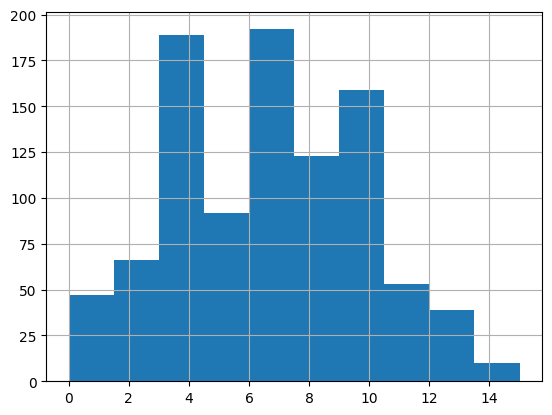

In [9]:
# histogram of wins
df_teams_stats.Win.hist()

<AxesSubplot: >

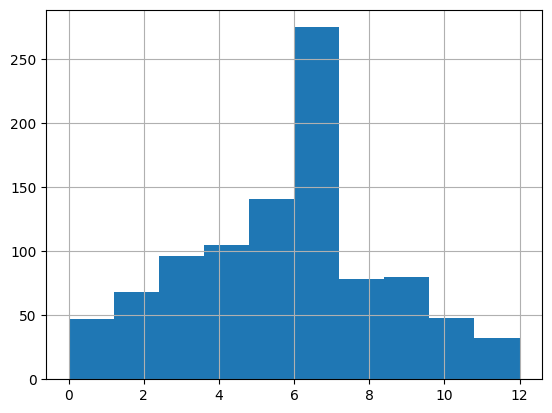

In [10]:
# histogram of losses
df_teams_stats.Loss.hist()

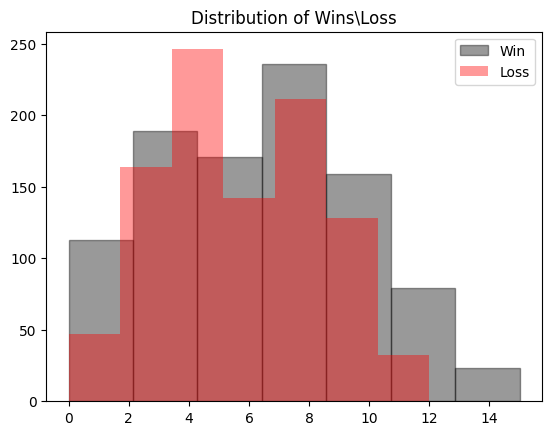

In [11]:
# histogram
hw = df_teams_stats.Win
hl = df_teams_stats.Loss

plt.title("Distribution of Wins\Loss")
plt.hist(hw, bins=7, edgecolor='Black', color= 'k', alpha=0.4)
plt.hist(hl, bins=7, edgecolor='None', color= 'r', alpha=0.4)
plt.legend(["Win", "Loss"], loc="upper right")
plt.show()

Here you can see a a slight skew to the right. Next we'll look at the recruits table.

In [12]:
df_recruits.head()

,Unnamed: 0,year,name,position,school,ranking,rating,stars,committed_to,recruit_type,height,weight,city,state_province,country,id,athlete_id
0,0,2012,Dorial Green-Beckham,WR,Hillcrest,1.0,0.9997,5,Missouri,HighSchool,78.0,220.0,Springfield,MO,USA,22037,531380.0
1,1,2012,Mario Edwards,DT,Ryan,2.0,0.9995,5,Florida State,HighSchool,75.0,285.0,Denton,TX,USA,22038,530290.0
2,2,2012,D.J. Humphries,OT,Mallard Creek,3.0,0.9979,5,Florida,HighSchool,77.0,275.0,Charlotte,NC,USA,22039,-1009881.0
3,3,2012,Shaq Thompson,S,Grant Union,4.0,0.9975,5,Washington,HighSchool,74.0,210.0,Sacramento,CA,USA,22040,535329.0
4,4,2012,Noah Spence,WDE,Bishop McDevitt,5.0,0.9974,5,Ohio State,HighSchool,75.0,235.0,Harrisburg,PA,USA,22041,-1027150.0


In [13]:
df_recruits.tail()

,Unnamed: 0,year,name,position,school,ranking,rating,stars,committed_to,recruit_type,height,weight,city,state_province,country,id,athlete_id
46398,46398,2023,Jacob Harris,WR,Westerville Central,2299.0,0.7844,2,Bowling Green,HighSchool,76.0,192.0,Westerville,OH,USA,94996,NaN
46399,46399,2023,Trey Dubuc,LS,Cardinal Gibbons,2300.0,0.7844,2,South Florida,HighSchool,74.0,220.0,Fort Lauderdale,FL,USA,94488,NaN
46400,46400,2023,Ezekiel Rodrigues,S,Mililani,2301.0,0.7833,2,Hawai'i,HighSchool,73.0,190.0,Mililani,HI,USA,95117,NaN
46401,46401,2023,DeAndre Beasley Jr.,CB,Bishop Miege,2302.0,0.7800,2,NaN,HighSchool,71.0,180.0,Lees Summit,MO,USA,94810,NaN
46402,46402,2023,Brady Probst,TE,Brownsburg,2303.0,0.7733,2,Illinois State,HighSchool,76.0,235.0,Brownsburg,IN,USA,94123,NaN


In [14]:
# rows and columns
df_recruits.shape

(46403, 17)

In [15]:
# looking for missing data, datatypes, column names
df_recruits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46403 entries, 0 to 46402
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      46403 non-null  int64  
 1   year            46403 non-null  int64  
 2   name            46403 non-null  object 
 3   position        46384 non-null  object 
 4   school          46123 non-null  object 
 5   ranking         46043 non-null  float64
 6   rating          46403 non-null  float64
 7   stars           46403 non-null  int64  
 8   committed_to    37882 non-null  object 
 9   recruit_type    46403 non-null  object 
 10  height          46305 non-null  float64
 11  weight          46301 non-null  float64
 12  city            46086 non-null  object 
 13  state_province  46075 non-null  object 
 14  country         46183 non-null  object 
 15  id              46403 non-null  int64  
 16  athlete_id      28536 non-null  float64
dtypes: float64(5), int64(4), object

We have a column called 'committed_to'.  This is important as it will be used later to match player names. In college football, recruiters visit high school athletes who want to play at the next level.

In [16]:
# looking at key statistics values 
df_recruits.describe()

,Unnamed: 0,year,ranking,rating,stars,height,weight,id,athlete_id
count,46403.000000,46403.000000,46043.000000,46403.000000,46403.000000,46305.000000,46301.000000,46403.000000,2.853600e+04
mean,23201.000000,2017.115941,1638.368438,0.821902,2.740211,73.807381,218.977387,49772.324957,2.935891e+06
std,13395.536607,3.156699,1134.999116,0.056273,0.683145,2.563885,45.283085,20172.348965,2.185014e+06
min,0.000000,2012.000000,1.000000,0.606300,1.000000,61.000000,20.000000,22037.000000,-1.044268e+06
25%,11600.500000,2014.000000,599.000000,0.779800,2.000000,72.000000,185.000000,33637.500000,5.480448e+05
50%,23201.000000,2017.000000,1541.000000,0.819800,3.000000,74.000000,206.000000,45238.000000,4.051451e+06
75%,34801.500000,2020.000000,2536.000000,0.855200,3.000000,76.000000,250.000000,63809.500000,4.430390e+06
max,46402.000000,2023.000000,4259.000000,1.000000,5.000000,84.000000,2000.000000,95120.000000,5.100583e+06


To refresh, the 'stars' indicate a future player's talent and abilities for each year. We will group the 4 and 5 star players and the 2 and 3 star players in their own group to be used in the analysis. Lets see the what the histograms look like. The important column here is the stars column. With a mean of 2.74, this confirms what the bulk of the distribution looks like, mostly 2- and 3-star players. The standard deviation shows that the values are clustered around the mean.

<AxesSubplot: >

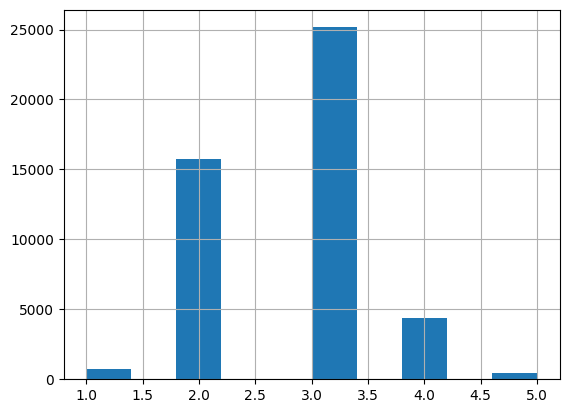

In [17]:
# histogram
df_recruits.stars.hist()

It's easy to see that 2 and 3 star players make up the bulk of this dataset. Let's get the same visual above using matplotlib, then we'll examine the counts of each star.

(array([  763., 15714., 25159.,  4349.,     0.,   418.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8]),
 <BarContainer object of 6 artists>)

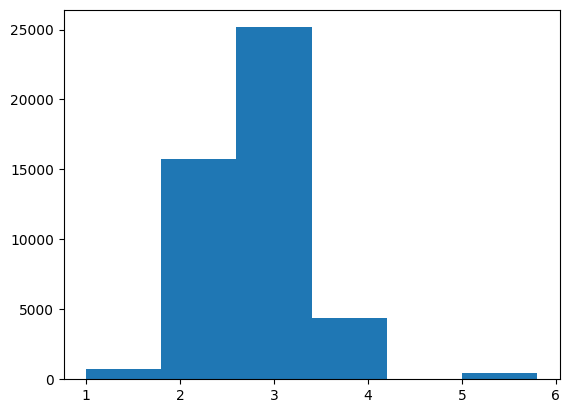

In [18]:
# histogram to show the distribution across the stars categories with matplotlib
data = df_recruits['stars']
plt.hist(data, bins=np.arange(min(data), max(data) + 1, .8))

The data is skewed to the right, which is indicative of the bulk of players being 2- and 3-stars. Not many are 5-stars. Let's get counts of each in the distribution.

In [19]:
# counting the categories
df_recruits[df_recruits['stars'] == 5].count()
# 418

df_recruits[df_recruits['stars'] == 4].count()
# 4349

df_recruits[df_recruits['stars'] == 3].count()
# 25159

df_recruits[df_recruits['stars'] == 2].count()
# 15714

df_recruits[df_recruits['stars'] == 1].count()
# 763

Unnamed: 0        763
year              763
name              763
position          763
school            762
ranking           761
rating            763
stars             763
committed_to      376
recruit_type      763
height            760
weight            760
city              762
state_province    761
country           761
id                763
athlete_id        208
dtype: int64

Now we can see the counts in each category. Let's examine the player statistics dataframes and the team they played on. We'll look at the defense, passing, receiving, rushing, and scoring position categories, as well as df_new. 'df_new' contains kicking, kickoff, kickoff-returns, punting, and punt-return statistics.

### DEFENSE

In [20]:
# defensive players
df_def.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Player     1000 non-null   object 
 1   Team       1000 non-null   object 
 2   Year       1000 non-null   int64  
 3   Int        1000 non-null   int64  
 4   TD         1000 non-null   int64  
 5   Solo       1000 non-null   int64  
 6   Ast        1000 non-null   int64  
 7   Tot        1000 non-null   int64  
 8   Sack       1000 non-null   float64
 9   Stat Type  1000 non-null   object 
dtypes: float64(1), int64(6), object(3)
memory usage: 78.2+ KB


### PASSING

In [21]:
df_pas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Player     1000 non-null   object 
 1   Team       1000 non-null   object 
 2   Year       1000 non-null   int64  
 3   Att        1000 non-null   int64  
 4   Cmp        1000 non-null   int64  
 5   Pct        1000 non-null   float64
 6   Yds        1000 non-null   object 
 7   TD         1000 non-null   int64  
 8   TD%        1000 non-null   float64
 9   Int        1000 non-null   int64  
 10  Sack       1000 non-null   object 
 11  Rate       1000 non-null   float64
 12  Stat Type  1000 non-null   object 
dtypes: float64(3), int64(5), object(5)
memory usage: 101.7+ KB


### RECEIVING

In [22]:
df_rec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Player     1000 non-null   object 
 1   Team       1000 non-null   object 
 2   Year       1000 non-null   int64  
 3   Rec        1000 non-null   int64  
 4   Yds        1000 non-null   object 
 5   Avg        1000 non-null   float64
 6   TD         1000 non-null   int64  
 7   Stat Type  1000 non-null   object 
dtypes: float64(1), int64(3), object(4)
memory usage: 62.6+ KB


### RUSHING

In [23]:
df_rus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Player     1000 non-null   object 
 1   Team       1000 non-null   object 
 2   Year       1000 non-null   int64  
 3   Att        1000 non-null   int64  
 4   Gain       1000 non-null   object 
 5   Loss       1000 non-null   int64  
 6   Yds        1000 non-null   object 
 7   Avg        1000 non-null   float64
 8   TD         1000 non-null   int64  
 9   Stat Type  1000 non-null   object 
dtypes: float64(1), int64(4), object(5)
memory usage: 78.2+ KB


### SCORING

In [24]:
df_sco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Player     700 non-null    object
 1   Team       700 non-null    object
 2   Year       700 non-null    int64 
 3   Pts        700 non-null    int64 
 4   Tot        700 non-null    int64 
 5   FG         700 non-null    object
 6   Stat Type  700 non-null    object
dtypes: int64(3), object(4)
memory usage: 38.4+ KB


### KICKING

In [25]:
df_kick.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Player     600 non-null    object
 1   Year       600 non-null    int64 
 2   Team       600 non-null    object
 3   Stat Type  600 non-null    object
dtypes: int64(1), object(3)
memory usage: 18.9+ KB


### KICKOFF

In [26]:
df_kickoff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Player     600 non-null    object
 1   Year       600 non-null    int64 
 2   Team       600 non-null    object
 3   Stat Type  600 non-null    object
dtypes: int64(1), object(3)
memory usage: 18.9+ KB


### KICKOFF RETURNS

In [27]:
df_kickoffR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Player     600 non-null    object
 1   Year       600 non-null    int64 
 2   Team       600 non-null    object
 3   Stat Type  600 non-null    object
dtypes: int64(1), object(3)
memory usage: 18.9+ KB


### PUNTING

In [28]:
df_punt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Player     514 non-null    object
 1   Year       514 non-null    int64 
 2   Team       514 non-null    object
 3   Stat Type  514 non-null    object
dtypes: int64(1), object(3)
memory usage: 16.2+ KB


### PUNT RETURNS

In [29]:
df_puntR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Player     600 non-null    object
 1   Year       600 non-null    int64 
 2   Team       600 non-null    object
 3   Stat Type  600 non-null    object
dtypes: int64(1), object(3)
memory usage: 18.9+ KB


In [30]:
# concat of five dataframes above(kicking, kickoff, kickoff-return, punt-return, punting) for simplicity
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2914 entries, 0 to 2913
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Player     2914 non-null   object
 1   Year       2914 non-null   int64 
 2   Team       2914 non-null   object
 3   Stat Type  2914 non-null   object
dtypes: int64(1), object(3)
memory usage: 91.2+ KB


<a id='eda'></a>
## 3. Exploratory Data Analysis

Next we'll perform some exploratory data analysis to look a little further. Using isnull() or isna() will show which columns have missing data and how much

In [31]:
# by column
df_teams_stats.isna().sum()

# in the entire dataset
df_teams_stats.isnull().sum().sum()

3

The 3 missing values in the team stats dataframe above are in the 'Conference' column. This column is not relevant for the analysis, so it's a non-issue.

In [32]:
df_recruits.isna().sum()

Unnamed: 0            0
year                  0
name                  0
position             19
school              280
ranking             360
rating                0
stars                 0
committed_to       8521
recruit_type          0
height               98
weight              102
city                317
state_province      328
country             220
id                    0
athlete_id        17867
dtype: int64

The recruits dataframe also shows many columns with missing data. Fortunately the most important columns in this dataset are the name, year, and stars. The 'committed to' column is also important and it will be used later. This values in this column will be assigned to a new column which will be the team they actually signed with and played for.

In [33]:
# no missing data in the defense, passing, receiving, rushing and scoring dataframes.
df_def.isna().sum()

# Player       0
# Team         0
# Year         0
# Int          0
# TD           0
# Solo         0
# Ast          0
# Tot          0
# Sack         0
# Stat Type    0

df_pas.isna().sum()

# Player       0
# Team         0
# Year         0
# Att          0
# Cmp          0
# Pct          0
# Yds          0
# TD           0
# TD%          0
# Int          0
# Sack         0
# Rate         0
# Stat Type    0


df_rec.isna().sum()

# Player       0
# Team         0
# Year         0
# Rec          0
# Yds          0
# Avg          0
# TD           0
# Stat Type    0


df_rus.isna().sum()

# Player       0
# Team         0
# Year         0
# Att          0
# Gain         0
# Loss         0
# Yds          0
# Avg          0
# TD           0
# Stat Type    0


df_sco.isna().sum()

# Player       0
# Team         0
# Year         0
# Pts          0
# Tot          0
# FG           0
# Stat Type    0

Player       0
Team         0
Year         0
Pts          0
Tot          0
FG           0
Stat Type    0
dtype: int64

In [34]:
# df_new
df_new.isna().sum()

Player       0
Year         0
Team         0
Stat Type    0
dtype: int64

In [35]:
# querying the dataset to create a subset
df_recruits2011_2022 = df_recruits.query('2011 <= year <= 2022')

#  additional rows have been added for year 2011
# df_recruits2011_2022 = df_recruits2012_2022


The teams dataset needs columns to store the two stars groups(2-3, 4-5) for calculating the blue chip ratio per team by year.

In [36]:
# 4-5 and 2-3 star players
df_teams_stats[['2_3.Stars', '4_5.Stars']] = ""


For consistency I'm renaming the 'name' column in the recruits table to 'Player'.

In [37]:
# the years range 2011_2022 at the end of the dataframe name is from a query to narrow down our subset.
df_recruits2011_2022.is_copy = False
df_recruits2011_2022.rename(columns={"name": "Player"}, inplace=True)

C:\Users\sjohn\AppData\Local\Temp\ipykernel_11856\3717788908.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recruits2011_2022.rename(columns={"name": "Player"}, inplace=True)


Again to be consistent, I'm moving the 'year' column to the front of the dataframe.

In [38]:
# using .pop for the move, then .insert
move_col = df_recruits2011_2022.pop("year")
df_recruits2011_2022.insert(2, "year", move_col)

Next I want to concatenate all of the players stats tables together for simplicity. Several columns will be dropped from the concat operation since they are unnecessary for the analysis.

In [39]:
# concatenating the five statistics categories 
df_concat1 = pd.concat([df_def, df_pas], ignore_index=True)
df_concat2 = pd.concat([df_concat1, df_rec], ignore_index=True)
df_concat3 = pd.concat([df_concat2, df_rus], ignore_index=True)

# final concat dataframe
df_concat_final = pd.concat([df_concat3, df_sco, df_new], ignore_index=True)


In [40]:
df_concat_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7614 entries, 0 to 7613
Data columns (total 22 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Player     7614 non-null   object 
 1   Team       7614 non-null   object 
 2   Year       7614 non-null   int64  
 3   Int        2000 non-null   float64
 4   TD         4000 non-null   float64
 5   Solo       1000 non-null   float64
 6   Ast        1000 non-null   float64
 7   Tot        1700 non-null   float64
 8   Sack       2000 non-null   object 
 9   Stat Type  7614 non-null   object 
 10  Att        2000 non-null   float64
 11  Cmp        1000 non-null   float64
 12  Pct        1000 non-null   float64
 13  Yds        3000 non-null   object 
 14  TD%        1000 non-null   float64
 15  Rate       1000 non-null   float64
 16  Rec        1000 non-null   float64
 17  Avg        2000 non-null   float64
 18  Gain       1000 non-null   object 
 19  Loss       1000 non-null   float64
 20  Pts     

As you can see multiple columns are the result of the concat operation.

Again for simplicity, I'm adding a 'Team_Played_For' column in the recruits data and assigning it to the values in the 'committed_to' column. This is because the majority of values listing the school they committed to are the same school they actually played for in the player stats table. This will save time later, because some minor editing tasks will need to be conducted to ensure that the team they committed to was the same they played on and is spelled and formatted correctly in the player stats dataset(df_concat_final). Unfortunately, I was unable to find an automated solution for this, so Excel will be used to edit the.csv files. I will locate the non-matches and set those non-matched schools to be same as the school name in the player statistics dataframe.

In [41]:
#  adding new column, 'Team_Played_For' to the recruits table set to the 'committed_to' column.
df_recruits2011_2022.assign(Team_Played_For = lambda x: df_recruits2011_2022['committed_to'])

,Unnamed: 0,Player,year,position,school,ranking,rating,stars,committed_to,recruit_type,height,weight,city,state_province,country,id,athlete_id,Team_Played_For
0,0,Dorial Green-Beckham,2012,WR,Hillcrest,1.0,0.9997,5,Missouri,HighSchool,78.0,220.0,Springfield,MO,USA,22037,531380.0,Missouri
1,1,Mario Edwards,2012,DT,Ryan,2.0,0.9995,5,Florida State,HighSchool,75.0,285.0,Denton,TX,USA,22038,530290.0,Florida State
2,2,D.J. Humphries,2012,OT,Mallard Creek,3.0,0.9979,5,Florida,HighSchool,77.0,275.0,Charlotte,NC,USA,22039,-1009881.0,Florida
3,3,Shaq Thompson,2012,S,Grant Union,4.0,0.9975,5,Washington,HighSchool,74.0,210.0,Sacramento,CA,USA,22040,535329.0,Washington
4,4,Noah Spence,2012,WDE,Bishop McDevitt,5.0,0.9974,5,Ohio State,HighSchool,75.0,235.0,Harrisburg,PA,USA,22041,-1027150.0,Ohio State
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43982,43982,T.Y. Harding,2022,ATH,Buckingham Browne & Nichols School,2220.0,0.7733,2,UMass,HighSchool,69.0,180.0,Cambridge,MA,USA,94369,4909541.0,UMass
43983,43983,Tate Zimmerman,2022,LB,Irvine,2221.0,0.7733,2,New Mexico,HighSchool,73.0,205.0,Irvine,CA,USA,92313,4912278.0,New Mexico
43984,43984,Nate Merchant,2022,LS,Easley,2222.0,0.7633,2,Coastal Carolina,HighSchool,73.0,205.0,Easley,SC,USA,92315,5082432.0,Coastal Carolina
43985,43985,Jack Tremblay,2022,WR,Lincoln-Way East,2223.0,0.7583,2,Central Michigan,HighSchool,72.0,190.0,Frankfort,IL,USA,92316,4895774.0,Central Michigan


In [42]:
# dropping 'Unnamed'column
df_recruits2011_2022.drop('Unnamed: 0', axis=1, inplace=True)

C:\Users\sjohn\AppData\Local\Temp\ipykernel_11856\3462704936.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recruits2011_2022.drop('Unnamed: 0', axis=1, inplace=True)


For now I will use an exact match process using .isin() to find the name matches.

In [43]:
# using .isin() to find name matches between the recruits and player statistics dataframe

df = df_recruits2011_2022[df_recruits2011_2022['Player'].isin(df_def['Player'])]
# checking if a recruit name matches a player name in the defense stats
# 468 

# # #  checking if a recruit name matches a player name in the passing stats
# # # 312
df1 = df_recruits2011_2022[df_recruits2011_2022['Player'].isin(df_pas['Player'])]

# # #  checking if a recruit name matches a player name in the receiving stats
# # # 427
df2 = df_recruits2011_2022[df_recruits2011_2022['Player'].isin(df_rec['Player'])]

# # #  checking if a recruit name matches a player name in the rushing stats
# # # 404
df3 =df_recruits2011_2022[df_recruits2011_2022['Player'].isin(df_rus['Player'])]

# # #  checking if a recruit name matches a player name in the scoring stats
# # # 337
df4 = df_recruits2011_2022[df_recruits2011_2022['Player'].isin(df_sco['Player'])]

# # #  checking if a recruit name matches a player name in the scoring stats
# # # 922
df5 =df_recruits2011_2022[df_recruits2011_2022['Player'].isin(df_new['Player'])]

df6 = pd.concat([df, df1, df2, df3, df4, df5], ignore_index=True)
# 468 + 312 + 427 + 404 + 337 + 922 = 2870

In [44]:
df6.rename({'year': 'Year'}, axis=1, inplace=True)
df6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2870 entries, 0 to 2869
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Player          2870 non-null   object 
 1   Year            2870 non-null   int64  
 2   position        2870 non-null   object 
 3   school          2869 non-null   object 
 4   ranking         2861 non-null   float64
 5   rating          2870 non-null   float64
 6   stars           2870 non-null   int64  
 7   committed_to    2658 non-null   object 
 8   recruit_type    2870 non-null   object 
 9   height          2869 non-null   float64
 10  weight          2867 non-null   float64
 11  city            2847 non-null   object 
 12  state_province  2846 non-null   object 
 13  country         2855 non-null   object 
 14  id              2870 non-null   int64  
 15  athlete_id      2573 non-null   float64
dtypes: float64(5), int64(3), object(8)
memory usage: 358.9+ KB


Merging the recruits dataset with the player statistics dataset, 'df_concat_final'.

In [45]:
df_recruits_players = pd.merge(df6, df_concat_final, on=['Player', 'Year'])

Checking for and removing duplicate rows

In [46]:
df_recruits_players.duplicated().value_counts()

False    661
True     321
dtype: int64

In [47]:
df_recruits_players.drop_duplicates(keep='first', inplace=True)

Removing columns that are not needed for the analysis.

In [48]:
# removing columnS not necessary for the analysis
cols = [3, 4, 5, 7, 8, 9, 10, 11, 15, 17, 18, 19, 20, 21, \
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
df_recruits_players.drop(df_recruits_players.columns[cols], axis=1, inplace=True)


In [49]:
df_recruits_players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 661 entries, 0 to 981
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Player          661 non-null    object
 1   Year            661 non-null    int64 
 2   position        661 non-null    object
 3   stars           661 non-null    int64 
 4   state_province  649 non-null    object
 5   country         654 non-null    object
 6   id              661 non-null    int64 
 7   Team            661 non-null    object
 8   FG              65 non-null     object
dtypes: int64(3), object(6)
memory usage: 51.6+ KB


In the second cell we read in our data. In the cell below, the 'recruits' and 'teams' dataframes are the cleaned datasets that were edited in Excel to resolve team names and spellings. The steps performed to this point are the same steps that were previously performed on the these two datasets.

In [50]:
# setting assignmaents for df_teams, df_recruits

df_recruits_players = recruits
df_teams_stats = teams

# renaming to match the df's in the cell below
df_teams = teams
df_recruits = df_recruits_players

The following cell is used to get the star counts between the 2 and 3-star and 4 and 5-star groups.

In [51]:
# getting the star counts for each player group
def remove_whitespace(df):
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    return df

df_recruits = remove_whitespace(df_recruits)
df_teams = remove_whitespace(df_teams)

# Assuming here to use Year_Played and not Year_Recruited
# Change it in line below if needed
year_col = 'Year_Played'
stars_counts = df_recruits.groupby(['Team', year_col])['Stars'].value_counts().unstack().fillna(0)

# Add '2' and '3' columns to form '2_3', '4' and '5' columns to form '4_5'
stars_counts['2_3'] = stars_counts.get(2, 0) + stars_counts.get(3, 0)
stars_counts['4_5'] = stars_counts.get(4, 0) + stars_counts.get(5, 0)

# Rename the columns to have .Stars
stars_counts.columns = [f'{col}.Stars' for col in stars_counts.columns]

# Reset index and rename column to do merge later with df_teams
stars_counts = stars_counts.reset_index(drop=False)
stars_counts = stars_counts.rename(columns={year_col: 'Year'})

# Merge to df_teams
df_teams = pd.merge(df_teams, stars_counts, how='left', on=['Team', 'Year'], suffixes=['_DROP','']).fillna(0)

# calculating the BRC
df_teams['Ratio'] = df_teams['2_3.Stars'].div(df_teams['4_5.Stars'])

# the Blue-Chip Ratio (BCR) column 
df_teams['BCR'] = ((df_teams['Ratio']) - 1).abs()


drop_cols = [col for col in df_teams.columns if col.endswith('_DROP')]
df_teams = df_teams.drop(columns=drop_cols)

df_teams.replace([np.inf, -np.inf], np.nan, inplace=True)

In [52]:
df_teams.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 970 entries, 0 to 969
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Team                    970 non-null    object 
 1   Conference              970 non-null    object 
 2   Year                    970 non-null    int64  
 3   Games                   970 non-null    int64  
 4   Win                     970 non-null    int64  
 5   Loss                    970 non-null    int64  
 6   Off.Yards.per.Game      970 non-null    float64
 7   Yards.Per.Game.Allowed  970 non-null    float64
 8   Touchdowns              970 non-null    int64  
 9   Touchdowns.Allowed      970 non-null    int64  
 10  1.Stars                 970 non-null    float64
 11  2.Stars                 970 non-null    float64
 12  3.Stars                 970 non-null    float64
 13  4.Stars                 970 non-null    float64
 14  5.Stars                 970 non-null    fl

The Blue Chip Ratio (BCR) is a measure of team talent. Ratios of 1 or greater are considered to have a low BCR which means that the total number of 2 and 3 star players on a team is greater than the counts of 4 and 5 star players. High BCR values are in the range between 0 and 1, indicating teams with a higher BCR.

In [53]:
# dropping additional columns
cols = [6, 7, 8, 9]
df_teams.drop(df_teams.columns[cols], axis=1, inplace=True)

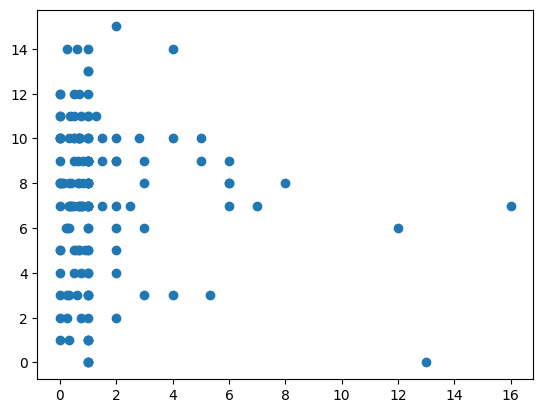

In [54]:
# quick scatter plot of the teams data
x = df_teams['BCR']
y = df_teams['Win']

plt.scatter(x, y)
plt.xlabel = 'BCR'
plt.ylabel = 'Win'
plt.show()

In [55]:
# removing outliers
df_teams = df_teams.query('BCR < 12')

Next we'll split the teams data into two subgroups, low and high blue-chip ratios. To refresh, the high BCR group are ratios between 0 and 1, indicating that teams in this BCR range had more 4- and 5-star players on their rosters when compared to the rest of the team(2- and 3-star players).

In [56]:
# high_bcr < 1
high_bcr = df_teams.query('0 < BCR < 1')

#low_bcr >= 1 
low_bcr = df_teams.query('BCR >= 1')

In [57]:
# high + low blue-chip ratios
bcr = df_teams.query('BCR > 0')
low_bcr =  low_bcr[low_bcr['Ratio'] > 1]
high_bcr = high_bcr[high_bcr['Ratio'] < 1]

In [58]:
# bcr.shape[0]
# high_bcr.sample(7)
high_bcr.query('BCR < 1').shape[0]
# low_bcr.query('BCR >= 1').shape[0]

39

In [59]:
high_bcr[high_bcr['Ratio'] < 1].count()

Team          39
Conference    39
Year          39
Games         39
Win           39
Loss          39
1.Stars       39
2.Stars       39
3.Stars       39
4.Stars       39
5.Stars       39
2_3.Stars     39
4_5.Stars     39
Ratio         39
BCR           39
dtype: int64

In [60]:
high_bcr.shape[0]

39

In [61]:
low_bcr.shape[0]

45

In [62]:
# concating high and low bcr together as bcr
bcr = pd.concat([high_bcr, low_bcr])

#### Obtaining the Correlation Coefficient

In [63]:
bcr['Win'].corr(bcr['BCR'])


0.0741544979368181

In [64]:
high_bcr['Win'].corr(high_bcr['BCR'])


0.1862957199155974

In [65]:
low_bcr['Win'].corr(low_bcr['BCR'])


0.09121918154992616

Since the correlation coefficient is closer to zero rather than 1 or -1, this is a strong indicator that the relationship between these two variables is weak.

In [66]:
# querying for top ten teams
df = pd.DataFrame(high_bcr, columns=['Team', 'Year', 'BCR'])
top_ten_bcr = df.nlargest(n=10, columns=['BCR'])

top_ten_bcr.BCR = top_ten_bcr.BCR.round(2)

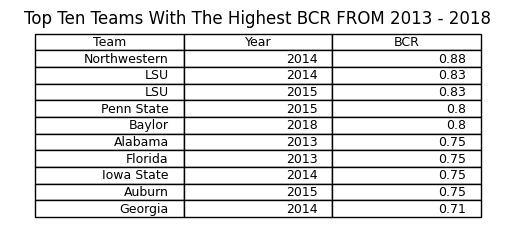

In [67]:
# creating a table of top ten teams
fig, ax = plt.subplots()
ax.axis('off')
ax.axis('auto')
ax.set_title('Top Ten Teams With The Highest BCR FROM 2013 - 2018')
fig.subplots_adjust(top=0.5)
tab = ax.table(cellText=top_ten_bcr.values, colWidths = [0.3]*len(top_ten_bcr.columns),  colLabels=top_ten_bcr.columns,  loc='center')
tab.auto_set_font_size(False) 
tab.set_fontsize(9)
tab.loc='center'
# fig.constrained_layout()
# display(topten)
plt.show()

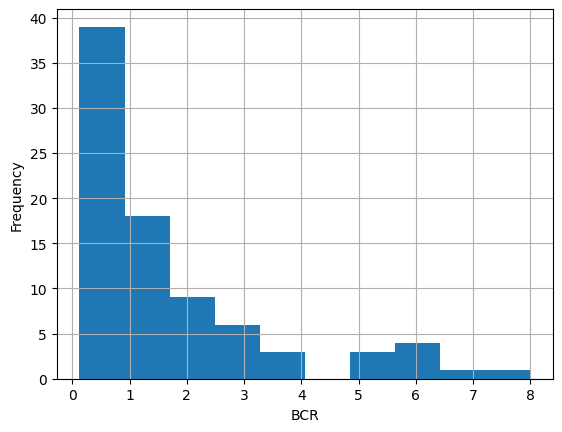

In [68]:
# use of reload() is due to an error I was unable to solve. Reloading matplotlib.pyplot seemed to fix it.
reload(plt)

plt.hist(bcr.BCR)
plt.xlabel('BCR')
plt.ylabel('Frequency')
plt.grid()


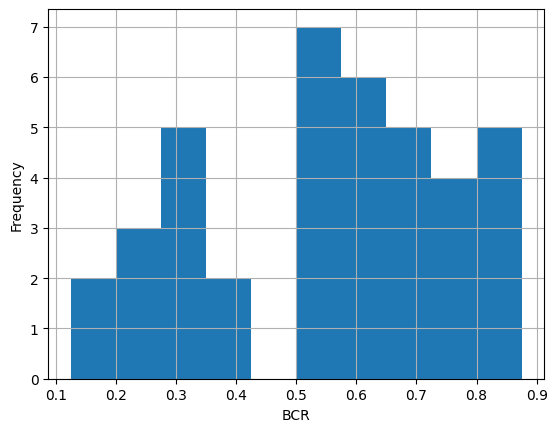

In [69]:
# high blue-chip ratio histogram
plt.hist(high_bcr.BCR)
plt.xlabel('BCR')
plt.ylabel('Frequency')
plt.grid()

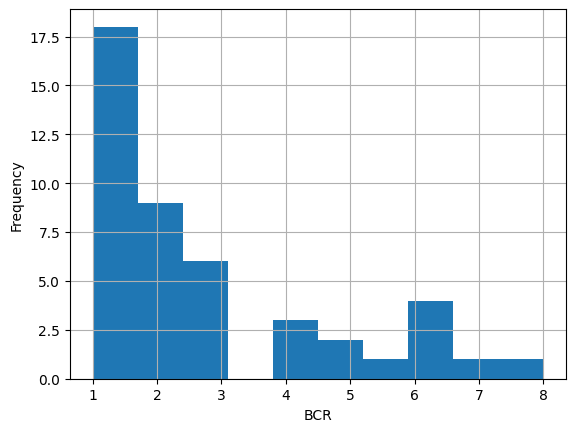

In [70]:
# low blue-chip ratio histogram
plt.hist(low_bcr.BCR)
plt.xlabel('BCR')
plt.ylabel('Frequency')
plt.grid()

In [71]:
# assigning arrays to dataframe columns for plotting

df = high_bcr['BCR']
df1 = low_bcr['BCR']
arr_hbcr = df.to_numpy().flatten()
arr_lbcr = df1.to_numpy().flatten()

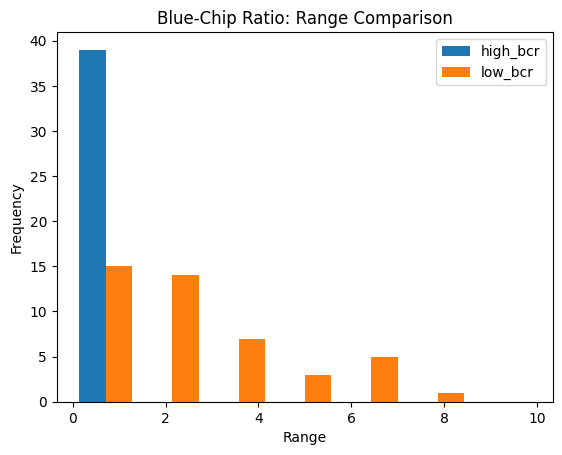

In [72]:
# histogram
fig = plt.figure() 
ax = fig.add_subplot()
plt.title("Blue-Chip Ratio: Range Comparison")
ax.set_xlabel('Range')
ax.set_ylabel('Frequency')

ax.hist([arr_hbcr, arr_lbcr], label=("high_bcr", "low_bcr"), range=[0, 10], bins=7)
ax.legend()

<a id='regression'></a>
## 4. Linear Regression

For this section we'll create simple linear regression models to be fitted to the data. I'll use Sklearn and Statsmodels to find out which method is more appropriate for our dataframes. We'll make use of scatter plots with Sklearn and Seaborn for  visualizations.

Before we can perform the analysis we need to do some housekeeping tasks and to assign our x,y variables. Our x values are high_bcr, low_bcr(x1) and bcr(x2), and the y value is our dependent variable, 'Win'. The "housekeeping" I am referring to is ensuring that the data is in a format the model can work with, a one dimensional array.

<a id='sk'></a>
### 4.1 Sklearn

In [73]:
# using Sklearn's train_test_split function to build linear regression model - high_bcr

X = np.array(high_bcr['BCR'].values.reshape(-1,1))
y = np.array(high_bcr['Win'].values.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

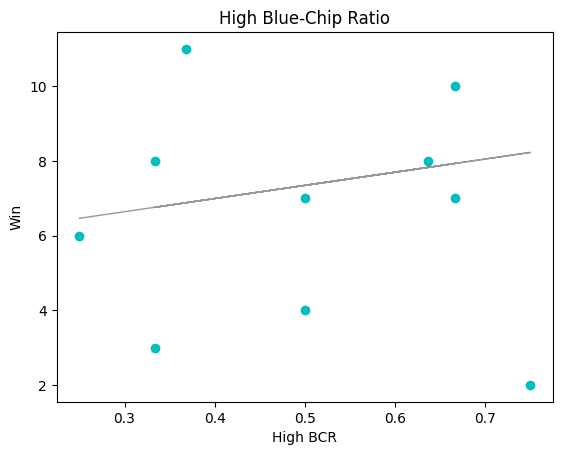

In [74]:
# high_bcr

regLR = LinearRegression()
regLR.fit(X_train, y_train)

y_pred = regLR.predict(X_test)

plt.scatter(X_test, y_test,  color='c')
plt.plot(X_test, y_pred, color='k', linewidth=1, alpha=0.4)
plt.title("High Blue-Chip Ratio")
plt.xlabel("High BCR")
plt.ylabel("Win")

# print(regLR.score(X_test, y_test))

plt.show()

In [75]:
# r-square
print(regLR.score(X_test, y_test))

-0.1531619035160281


In [76]:
# using Sklearn's train_test_split function to build linear regression model - low_bcr

X = np.array(low_bcr['BCR'].values.reshape(-1,1))
y = np.array(low_bcr['Win'].values.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

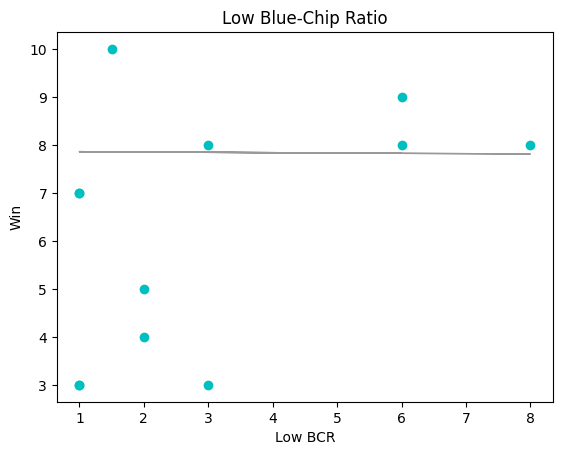

In [77]:
# low_bcr

regLR1 = LinearRegression()
regLR1.fit(X_train, y_train)

y_pred = regLR1.predict(X_test)


plt.scatter(X_test, y_test,  color='c')
plt.plot(X_test, y_pred, color='k', linewidth=1, alpha=0.4)
plt.title("Low Blue-Chip Ratio")
plt.xlabel("Low BCR")
plt.ylabel("Win")

# print(regLR.score(X_test, y_test))

plt.show()

In [78]:
# using Sklearn's train_test_split function to build linear regression model - all_data(bcr)

X = np.array(bcr['BCR'].values.reshape(-1,1))
y = np.array(bcr['Win'].values.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

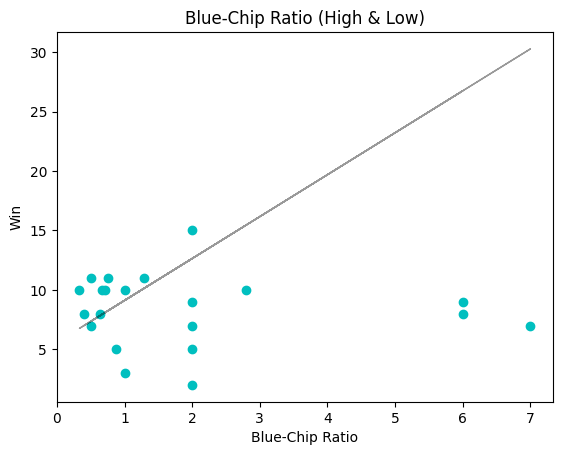

In [79]:
# bcr

regLR2 = LinearRegression()
regLR2.fit(X_train, y_train)

y_pred = regLR.predict(X_test)

plt.scatter(X_test, y_test,  color='c')
plt.plot(X_test, y_pred, color='k', linewidth=1, alpha=0.4)
plt.title("Blue-Chip Ratio (High & Low)")
plt.xlabel("Blue-Chip Ratio")
plt.ylabel("Win")

# print(regLR.score(X_test, y_test))

plt.show()

Let's check some statistical values.

In [80]:
print("High Blue-Chip Ratio")
print("BCR: intercept:", regLR.intercept_, " coefficient:", regLR.coef_, "R-square: ", regLR.score(X_test, y_test))

High Blue-Chip Ratio
BCR: intercept: [5.58137766]  coefficient: [[3.52768192]] R-square:  -7.776195557815321


In [81]:
print("Low Blue-Chip Ratio")
print("BCR: intercept:", regLR1.intercept_, " coefficient:", regLR1.coef_, "R-square: ", regLR1.score(X_test, y_test))

Low Blue-Chip Ratio
BCR: intercept: [7.86649059]  coefficient: [[-0.00691569]] R-square:  -0.03230522099280142


In [82]:
print("All Blue-Chip Ratio")
print("BCR: intercept:", regLR2.intercept_, " coefficient:", regLR2.coef_, "R-square: ", regLR2.score(X_test, y_test))

All Blue-Chip Ratio
BCR: intercept: [6.700917]  coefficient: [[0.20401538]] R-square:  -0.23773764647378548


<a id='sm'></a>
### 4.2 Statsmodels

In [83]:
# reshaping the data to 1-D array with Numpy

# high_bcr
x = np.array(high_bcr['BCR'].values.reshape(-1,1))
y = np.array(high_bcr['Win'].values.reshape(-1,1))

# # low_bcr
x1 = np.array(low_bcr['BCR'].values.reshape(-1,1))
y1 = np.array(low_bcr['Win'].values.reshape(-1,1))

# # bcr
x2 = np.array(bcr['BCR'].values.reshape(-1,1))
y2 = np.array(bcr['Win'].values.reshape(-1,1))


                            OLS Regression Results                            
Dep. Variable:                    Win   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.330
Date:                Thu, 17 Aug 2023   Prob (F-statistic):              0.256
Time:                        13:15:23   Log-Likelihood:                -98.114
No. Observations:                  39   AIC:                             200.2
Df Residuals:                      37   BIC:                             203.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7525      1.435      4.008      0.0

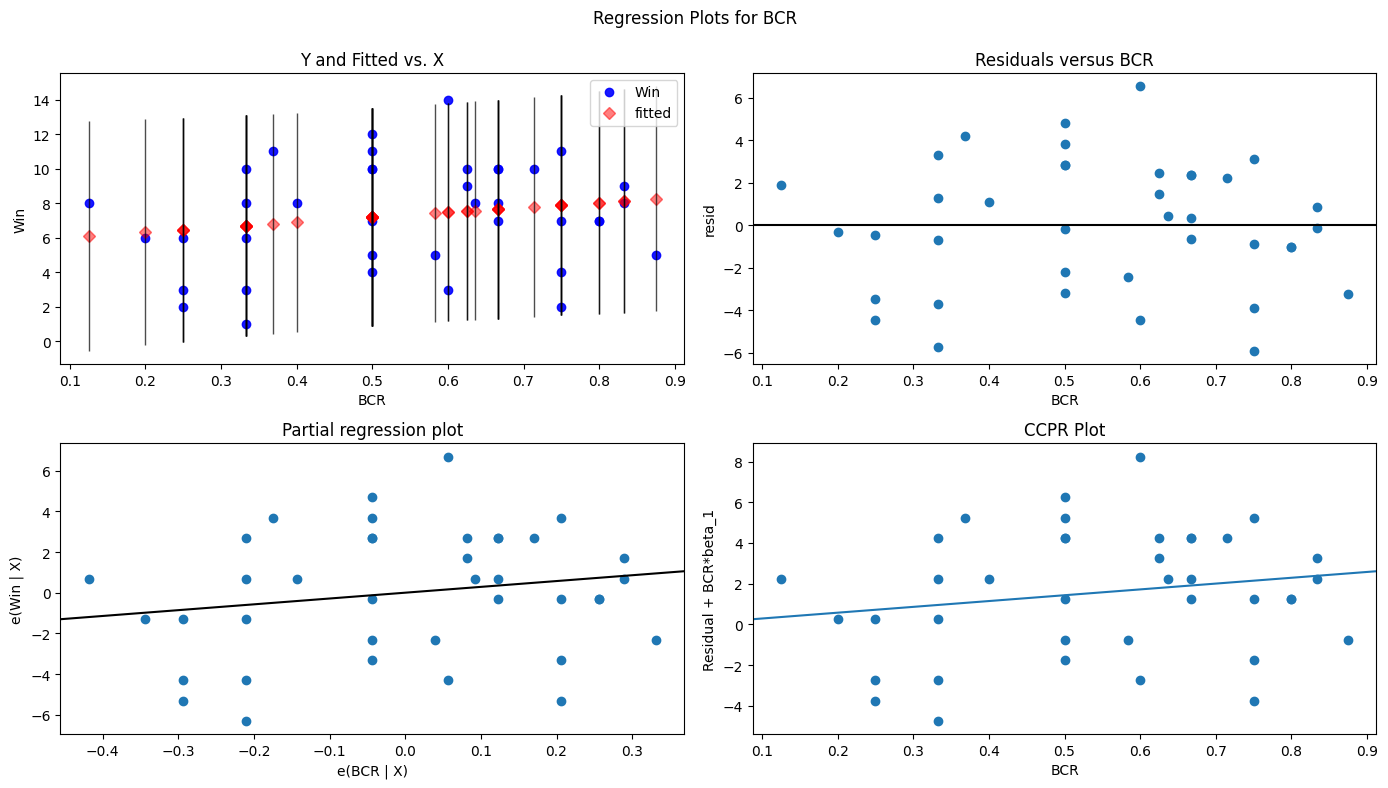

In [84]:
# from statsmodels OLS linear regression
#  high bcr

x = high_bcr['BCR']
y = high_bcr['Win']

X2 = sm.add_constant(x)

mod = sm.OLS(y, X2)
result = mod.fit()

print(result.summary())


# regression plots with residuals
fig = plt.figure(figsize=(14, 8))

fig = sm.graphics.plot_regress_exog(result, 'BCR', fig=fig)

                            OLS Regression Results                            
Dep. Variable:                    Win   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.3608
Date:                Thu, 17 Aug 2023   Prob (F-statistic):              0.551
Time:                        13:15:24   Log-Likelihood:                -114.81
No. Observations:                  45   AIC:                             233.6
Df Residuals:                      43   BIC:                             237.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.0209      0.819      8.575      0.0

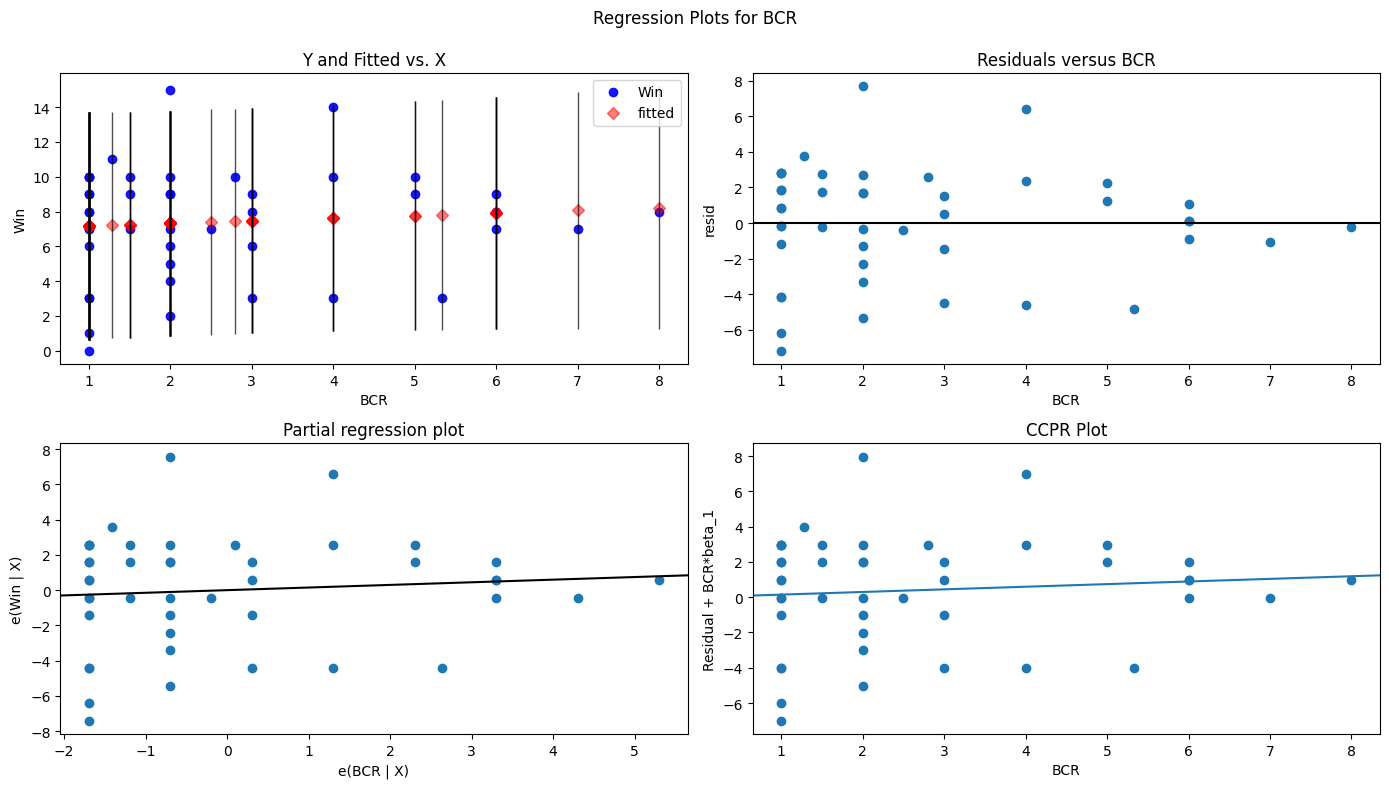

In [85]:
# from statsmodels
# low bcr

x1 = low_bcr['BCR']
y1 = low_bcr['Win']

X2 = sm.add_constant(x1)

mod = sm.OLS(y1, X2)
result = mod.fit()

print(result.summary())

# regression plots with residuals
fig = plt.figure(figsize=(14, 8))
fig = sm.graphics.plot_regress_exog(result, 'BCR', fig=fig)

                            OLS Regression Results                            
Dep. Variable:                    Win   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.4534
Date:                Thu, 17 Aug 2023   Prob (F-statistic):              0.503
Time:                        13:15:25   Log-Likelihood:                -213.60
No. Observations:                  84   AIC:                             431.2
Df Residuals:                      82   BIC:                             436.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.1495      0.471     15.181      0.0

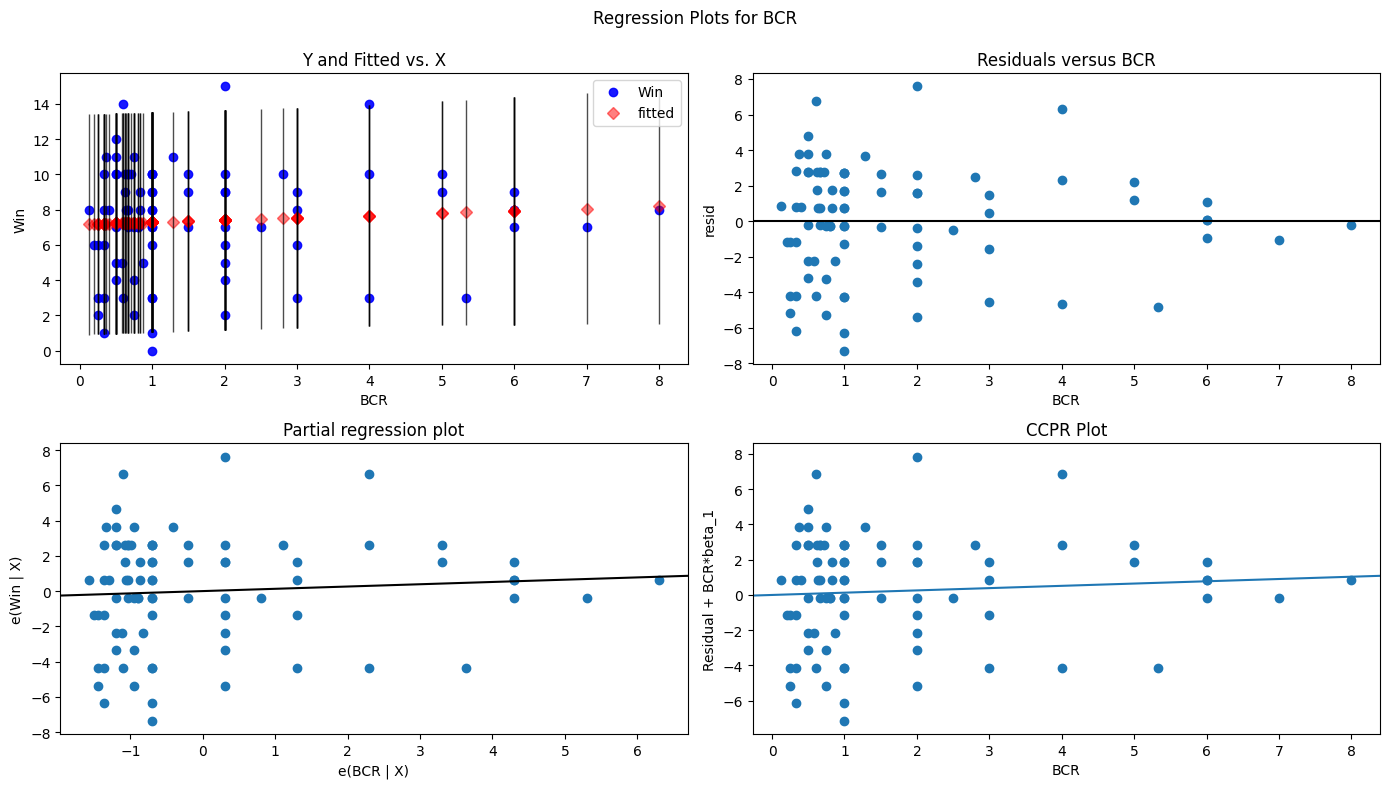

In [86]:
# from statsmodels

# bcr = high and low bcr

x2 = bcr['BCR']
y2 = bcr['Win']

X3 = sm.add_constant(x2)

mod = sm.OLS(y2, X3)
result = mod.fit()

print(result.summary())

# regression plots with residuals
fig = plt.figure(figsize=(14, 8))
fig = sm.graphics.plot_regress_exog(result, 'BCR', fig=fig)

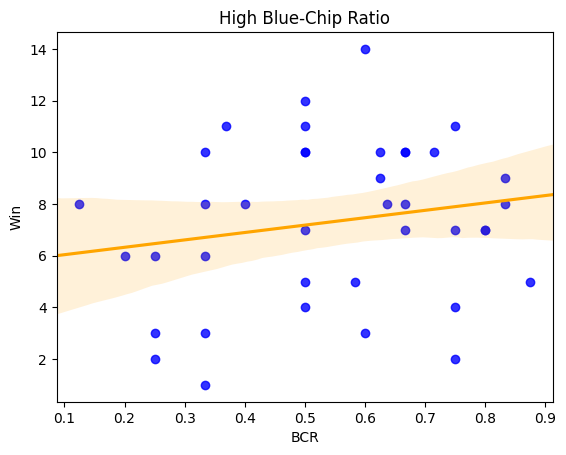

In [87]:
#  using seaborn's regplot
x = high_bcr['BCR']
y = high_bcr['Win']

ax = sns.regplot(x, y, scatter_kws={"color": "blue"}, line_kws={"color": "orange"})
plt.title("High Blue-Chip Ratio")
plt.show()

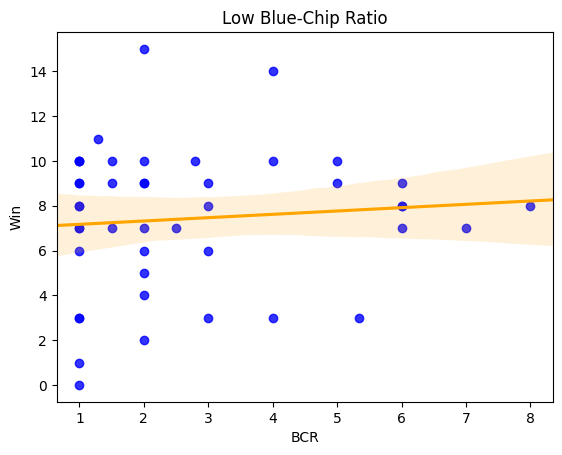

In [88]:
x = low_bcr['BCR']
y = low_bcr['Win']

ax = sns.regplot(x, y, scatter_kws={"color": "blue"}, line_kws={"color": "orange"})
plt.title("Low Blue-Chip Ratio")
plt.show()

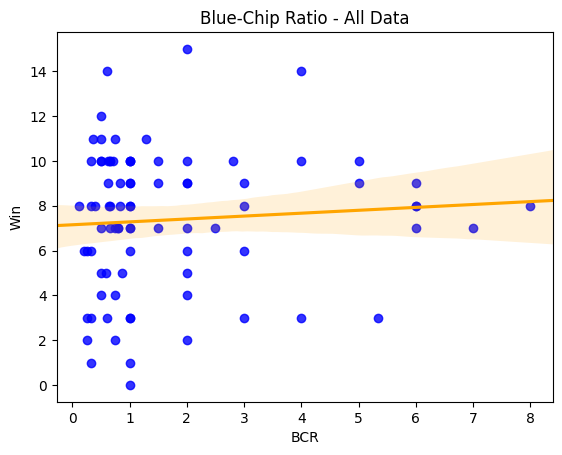

In [89]:
x = bcr['BCR']
y = bcr['Win']

ax = sns.regplot(x, y, scatter_kws={"color": "blue"}, line_kws={"color": "orange"})
plt.title("Blue-Chip Ratio - All Data")
plt.show()

<a id='conclusion'></a>
## Conclusion

These were challenging datasets to work with. The choice to use Sklearn was simply to validate the suitability of the data for regression; it is clear from the scatter plots that the data did not fit the trend lines well, probably due a variety of factors, the main one being the small sample size. Outliers were also a challenge when deciding on what range of values to keep. Statsmodels results did not fare much better as it illustrates some heteroscedasticity, or unequal variances between points, as shown in the residual plots.

In the summary tables, the very low r-square values informs me that only 0.8% of high and low blue-chip ratios or less than 1% of the variability in our dependent variable y can be explained by x. The p-values of 0.5 (high bcr), 0.48 (low bcr), and 0.6 (all) confirm that this observation is not statistically significant, that the evidence is weak against the null hypothesis. This means, based on the results provided in this analysis that the blue-chip ratio does not have a real impact on wins or losses in college football, leading me to not reject the null hypothesis.

## Key Takeaways and Implications

 - P-values are not statistically significant, > 0.05<br>
 
 - R^2 values close to 0<br>
 
 - Size of the data was very small and challenging to work with
 
Based to the results of this data, the implications are that the blue-chip ratio is not a major contributing factor in winning games in college football. Had the results been statistically significant, it could imply that college football programs should consider re-examining their respective recruiting strategies when building team rosters.
